In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') # Limpar avisos de conversão de data

In [ ]:
# Carregar dados
df = pd.read_csv('spotify_songs_pedro.csv')
df['ts'] = pd.to_datetime(df['ts'])
df['min_played'] = df['ms_played'] / 60000

# Criar identificador de Ano-Mês
df['ano_mes'] = df['ts'].dt.to_period('M')

df = df[(df['skipped'] == False) | (df['shuffle'] == False)]  

# Agrupar por música e mês para facilitar o treino
df_grouped = df.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name', 'ano_mes'])['min_played'].sum().reset_index()

def get_period_data(df_base, start_month, end_month):
    """Filtra o dataframe entre dois períodos (ex: '2024-11' até '2025-01')"""
    return df_base[(df_base['ano_mes'] >= start_month) & (df_base['ano_mes'] <= end_month)]

In [3]:
def prever_ano_completo(df_treino, meses_a_prever=9):
    previsoes_totais = []
    
    # Identificar músicas únicas no período de treino
    musicas = df_treino[['master_metadata_track_name', 'master_metadata_album_artist_name']].drop_duplicates()
    
    for _, row in musicas.iterrows():
        m, a = row['master_metadata_track_name'], row['master_metadata_album_artist_name']
        
        # Filtra dados da música e garante ordem cronológica
        dados_m = df_treino[(df_treino['master_metadata_track_name'] == m) & 
                            (df_treino['master_metadata_album_artist_name'] == a)].sort_values('ano_mes')
        
        # Se tivermos menos de 2 meses, a regressão é instável, mas o código lida com isso
        X = np.array(range(len(dados_m))).reshape(-1, 1)
        y = dados_m['min_played'].values
        
        # Treinar modelo linear
        model = LinearRegression()
        model.fit(X, y)
        
        # Prever os 9 meses seguintes
        X_futuro = np.array(range(len(dados_m), len(dados_m) + meses_a_prever)).reshape(-1, 1)
        y_pred = model.predict(X_futuro)
        y_pred = np.clip(y_pred, 0, None) # Minutos não podem ser negativos
        
        total_ano = y.sum() + y_pred.sum()
        
        previsoes_totais.append({
            'musica': m,
            'artista': a,
            'min_reais_treino': y.sum(),
            'total_estimado': total_ano
        })
        
    return pd.DataFrame(previsoes_totais).sort_values(by='total_estimado', ascending=False)

In [4]:
# 1. Treino: Nov/23, Dez/23, Jan/24
df_val_treino = get_period_data(df_grouped, '2024-11', '2025-01')

# 2. Realidade total para comparar: Nov/23 até Out/24 (12 meses)
df_val_real_12m = get_period_data(df_grouped, '2024-11', '2025-10')
df_real_soma = df_val_real_12m.groupby(['master_metadata_track_name', 'master_metadata_album_artist_name'])['min_played'].sum().reset_index()
df_real_soma.columns = ['musica', 'artista', 'total_real']

# 3. Rodar previsão baseada nos 3 meses iniciais
df_previsao_teste = prever_ano_completo(df_val_treino)

# 4. Cruzar e calcular métricas
df_metrics = pd.merge(df_previsao_teste, df_real_soma, on=['musica', 'artista'], how='inner')

mae = mean_absolute_error(df_metrics['total_real'], df_metrics['total_estimado'])
r2 = r2_score(df_metrics['total_real'], df_metrics['total_estimado'])

print(f"--- RESULTADOS DA VALIDAÇÃO (2024) ---")
print(f"MAE (Erro Médio): {mae:.2f} min")
print(f"R² (Precisão da Tendência): {r2:.4f}")
print("-" * 40)
print("Top 5 Comparativo (Real vs Estimado):")
print(df_metrics[['musica', 'total_real', 'total_estimado']].head(5))

--- RESULTADOS DA VALIDAÇÃO (2024) ---
MAE (Erro Médio): 47.04 min
R² (Precisão da Tendência): -1.7642
----------------------------------------
Top 5 Comparativo (Real vs Estimado):
                                              musica  total_real  \
0                     Tudo Que Você Quiser - Ao Vivo  170.345117   
1                          Caso Indefinido - Ao Vivo  267.948467   
2                           Cuida Bem Dela - Ao Vivo  193.775433   
3  40 Graus / Gamei / Azul Sem Fim / Até o Sol Qu...   22.587183   
4                        Amar Não é Pecado - Ao Vivo  198.568833   

   total_estimado  
0     1201.275717  
1      842.879767  
2      623.333333  
3      550.244567  
4      415.789183  


--- O SEU TOP 2026 PREVISTO ---
                                                musica               artista  \
299  Pot-Pourri: Melhor Eu Ir / Ligando Os Fatos / ...    Grupo Menos É Mais   
183                                I Ran (So Far Away)   A Flock Of Seagulls   
151                                         Evidências  Chitãozinho & Xororó   
383                                         The Ringer                Eminem   
158                                     Final De Tarde              Péricles   
34        Another One Bites The Dust - Remastered 2011                 Queen   
30          Amo Noite E Dia - Live In Sao Paulo / 2010        Jorge & Mateus   
340                          Sinto sua falta - Ao vivo              Ferrugem   
301                       Pra você acreditar - Ao vivo              Ferrugem   
433                                    hot girl bummer             blackbear   

     total_estimado  
299     1050.846133  
183      944.260717  
151      910.806233  

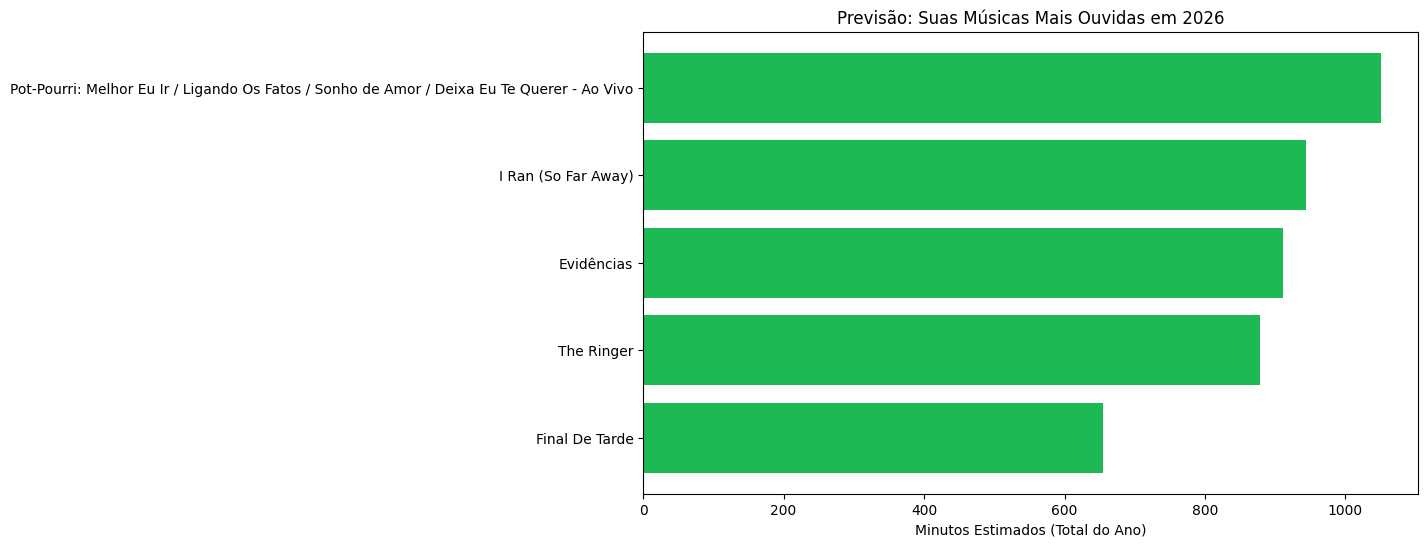

In [5]:
# Treino: Nov/25, Dez/25, Jan/26
df_2026_treino = get_period_data(df_grouped, '2025-11', '2026-01')

# Gerar resultado final
resultado_2026 = prever_ano_completo(df_2026_treino)

print("--- O SEU TOP 2026 PREVISTO ---")
print(resultado_2026[['musica', 'artista', 'total_estimado']].head(10))

# Visualização simples do Top 5
top5 = resultado_2026.head(5)
plt.figure(figsize=(10, 6))
plt.barh(top5['musica'], top5['total_estimado'], color='#1DB954')
plt.xlabel('Minutos Estimados (Total do Ano)')
plt.title('Previsão: Suas Músicas Mais Ouvidas em 2026')
plt.gca().invert_yaxis()
plt.show()